In [26]:
NOTEBOOK_NAME = "sample_baseline_lgbm_pandas"

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib

In [3]:
train = pd.read_csv("../sample_data/train.csv")
test = pd.read_csv("../sample_data/test.csv")
sample_submission = pd.read_csv("../sample_data/gender_submission.csv")

# データ型の変更

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
categorical_cols = ["Sex", "Ticket", "Cabin", "Embarked"]

In [6]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Fold

In [11]:
# Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
FOLD_NUM = 5

skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
for fold, (_, v_idx) in enumerate(skf.split(train, train["Survived"])):
    train.loc[v_idx, "fold"] = fold

train["fold"] = train["fold"].astype(int)

# LightGBM

In [12]:
use_col = []

base_col = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

use_col += base_col
use_col += categorical_cols

len(use_col)

9

In [13]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.05,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
}

In [15]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop("Survived", axis=1)
    X_valid = valid_fold.drop("Survived", axis=1)
    y_train = train_fold[["Survived"]]
    y_valid = valid_fold[["Survived"]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100)
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

Start fold 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	training's auc: 0.921775	valid_1's auc: 0.913175
fold 0 Score: 0.9131752305665349
Start fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	training's auc: 0.886246	valid_1's auc: 0.886364
fold 1 Score: 0.8863636363636364
Start fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	training's auc: 0.918166	valid_1's auc: 0.84492
fold 2 Score: 0.8449197860962566
Start fold 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	training's auc: 0.929526	valid_1's auc: 0.866912
fold 3 Score: 0.8669117647058824
Start fold 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.886826	valid_1's auc: 0.895227
fold 4 Score: 0.8952266985773168


In [16]:
oof_score = roc_auc_score(y_true=train["Survived"], y_score=oof)
oof_score

0.8733289660094377

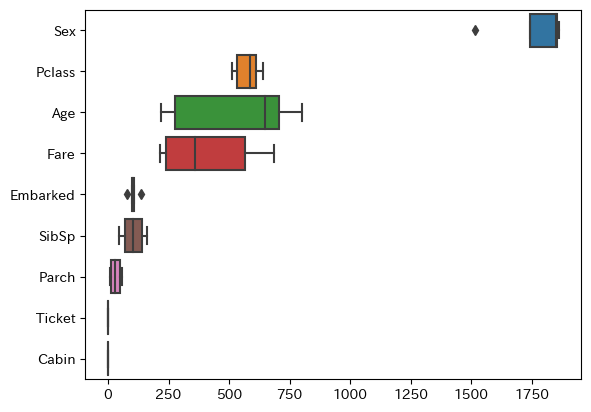

In [23]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=use_col)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [18]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test[use_col]) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

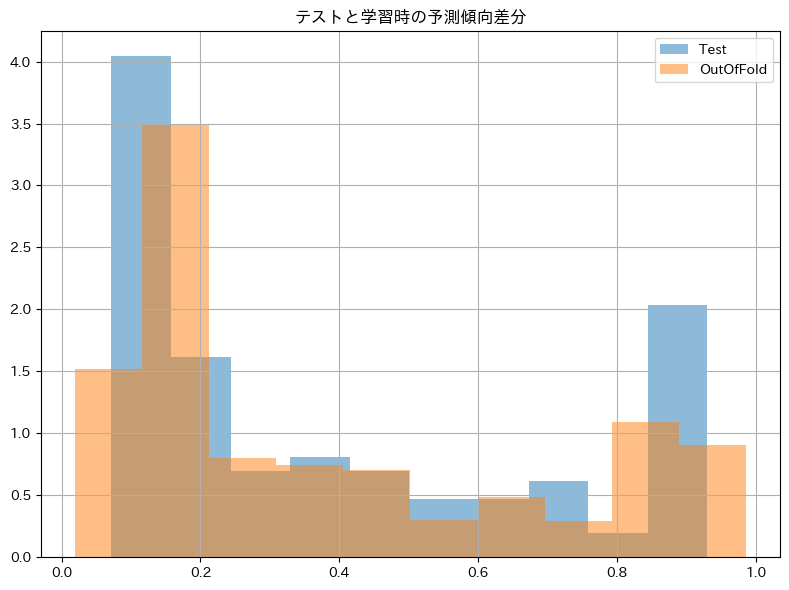

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [25]:
sample_submission["Survived"] = (pred > 0.5).astype(int)
sample_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [28]:
sample_submission.to_csv(f"../sub/{NOTEBOOK_NAME}_{oof_score:.4f}.csv", index=False)